##### imports

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import pickle 


##### reading data

In [2]:
### reading data including individual tumour growth rates
df_all = pd.read_csv("clean_erlotinib.csv") # to see markers etc
total_tumors_df = pd.read_csv("total_tumors.csv")
single_tumors_df = pd.read_csv("single_tumors.csv")
total_tumors_df.head()
ten_plus_df = pd.read_csv("ten_plus.csv")
eight_plus_df = pd.read_csv("eight_plus.csv")
no_first_point_df = pd.read_csv("no_first_point.csv")

## Logistic 

#### Log linear 2 growth rates

In [29]:
#### with 2 r
# Logistic population model
def system_ode_logistic(time, populations, params, kill_rate='linear'):
    Spop = populations[0]
    Rpop = populations[1]
    r1 = params[0] #growth rate
    r2 = params[1] #growth rate
    kmax = params[2] #carrying capacity
    lam = params[3] #death rate due to medication
    C = 1 # drug concentration, if

    if kill_rate == 'linear':
        dSpop_dt = Spop * (r1 * (1- (Spop + Rpop)/kmax) - lam*C) # linear kill rate
    elif kill_rate == 'NS':
        dSpop_dt = Spop * (r1 * (1- (Spop + Rpop)/kmax))*(1-lam*C) # Norton-Simon kill rate
    else:
        raise ValueError("Invalid kill_rate. Expected 'linear' or 'NS'.")

    dRpop_dt = Rpop * (r2 * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function for logistic population model
    
def cost_func_logistic(params, time, data, kill_rate='linear'):
    initial_populations = params[-2:]
    tspan = [time[0], time[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(time), args = (params[:4], kill_rate))
    
    if pred_data_log.y.shape[1] == np.ravel(time).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        rmse = np.sqrt(msq_error)
        # pseudo huber loss
        delta = 100
        huber_loss = np.sum(np.where(np.abs(sum_pops - data) < delta, 0.5*(sum_pops - data)**2, delta*(np.abs(sum_pops - data) - 0.5*delta)))/len(data)
    else: 
        msq_error = 1e30
        rmse = 1e30
        mean_abs_error = 1e30
        huber_loss = 1e30

    #return mean_abs_error
    #return msq_error
    return rmse
    #return huber_loss

####################################################################################

##### basic logistic, linear kill rate
#### use total tumors df
df = eight_plus_df
unique_IDs = df.ID.unique()
md_constant_log_linear_2r = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    kill_rate = 'linear' # linear or NS 

    print("Working on patient:", id, " Number of data points:", len(days))
    if kill_rate == 'linear':
        bounds = [(1e-4, 5e-1), (1e-4,5e-1),# r1, r2
                  (1.5*max_value, 10*max_value), (5e-3, 2e-1), #K,lambda
                  (0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # spop0, rpop0
    elif kill_rate == 'NS':   
        bounds = [(5e-1, 5e-1), (5e-1, 5e-1), # r1, r2
                  (1.5*max_value, 10*max_value), (0.1,10),#K,lambda
                  (0.8*data[0], data[0]-1e-2),(1e-5,0.2*data[0])] # spop0,rpop0

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, 
                                            args=(days, data, kill_rate),
                                             maxiter=100, popsize=10, disp=True)
    
    # Calculate the predictions using the optimal parameters
    optimal_params = opt_result_log.x
    pred_data_log = solve_ivp(system_ode_logistic, [0, days[-1]], optimal_params[4:],
                              t_eval=days, args=(optimal_params[:4], kill_rate))
    sum_pops = np.sum(pred_data_log.y, axis=0)

    # Calculate R-squared and AIC
    ss_res = np.sum((data - sum_pops) ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    n = len(data)  # number of data points
    k = len(optimal_params)  # number of parameters
    aic = n * np.log(ss_res / n) + 2 * k

    # store the optimal parameters and the cost function value (last entry in list)
    md_constant_log_linear_2r[id] = optimal_params.tolist() + [opt_result_log.fun, aic, r_squared]

   

Working on patient: A1002  Number of data points: 16
differential_evolution step 1: f(x)= 33.4621
differential_evolution step 2: f(x)= 33.4621
differential_evolution step 3: f(x)= 28.1307
differential_evolution step 4: f(x)= 7.13124
differential_evolution step 5: f(x)= 7.13124
differential_evolution step 6: f(x)= 6.96413
differential_evolution step 7: f(x)= 6.96413
differential_evolution step 8: f(x)= 6.96413
differential_evolution step 9: f(x)= 6.96413
differential_evolution step 10: f(x)= 6.96413
differential_evolution step 11: f(x)= 6.63424
differential_evolution step 12: f(x)= 5.01474
differential_evolution step 13: f(x)= 5.01474
differential_evolution step 14: f(x)= 5.01474
differential_evolution step 15: f(x)= 5.01474
differential_evolution step 16: f(x)= 5.01474
differential_evolution step 17: f(x)= 4.67595
differential_evolution step 18: f(x)= 4.67595
differential_evolution step 19: f(x)= 4.58772
differential_evolution step 20: f(x)= 4.58772
differential_evolution step 21: f(x)

In [30]:
df_log_alpha_linear_2r = pd.DataFrame.from_dict(md_constant_log_linear_2r, orient='index', 
                                     columns=['rs', 'rr', 'K', 'lambda', 
                                      'S_0', 'R_0', 'rmse', 'aic', 'r_squared'  ])

df_log_alpha_linear_2r.to_csv("eight_plus_log_alpha_linear.csv")
df_log_alpha_linear_2r

,rs,rr,K,lambda,S_0,R_0,rmse,aic,r_squared
A1002,0.193328,0.021549,104.775873,0.188126,43.408456,0.000012,1.668708,28.385597,0.978217
A1006,0.000100,0.000826,331.108535,0.040153,54.399222,2.124910,0.136819,-19.825526,0.999940
A1007,0.188815,0.004586,60.303144,0.137969,34.493349,5.105137,1.413801,21.003319,0.948923
A1008,0.000100,0.001459,359.427236,0.023333,33.989127,4.434403,0.896152,9.368501,0.988992
A1012,0.068510,0.002533,95.161776,0.056315,44.356110,6.375662,4.835167,40.366484,0.777041
A1014,0.205163,0.007131,1.828458,0.198201,0.830990,0.000222,0.026429,-118.798924,0.983679
A1016,0.035099,0.001510,504.006926,0.098749,100.173850,4.221562,0.848656,7.405171,0.998850
E1012,0.000122,0.001376,62.369487,0.010320,22.053003,4.439618,1.329342,21.109898,0.922848


##### Plotting

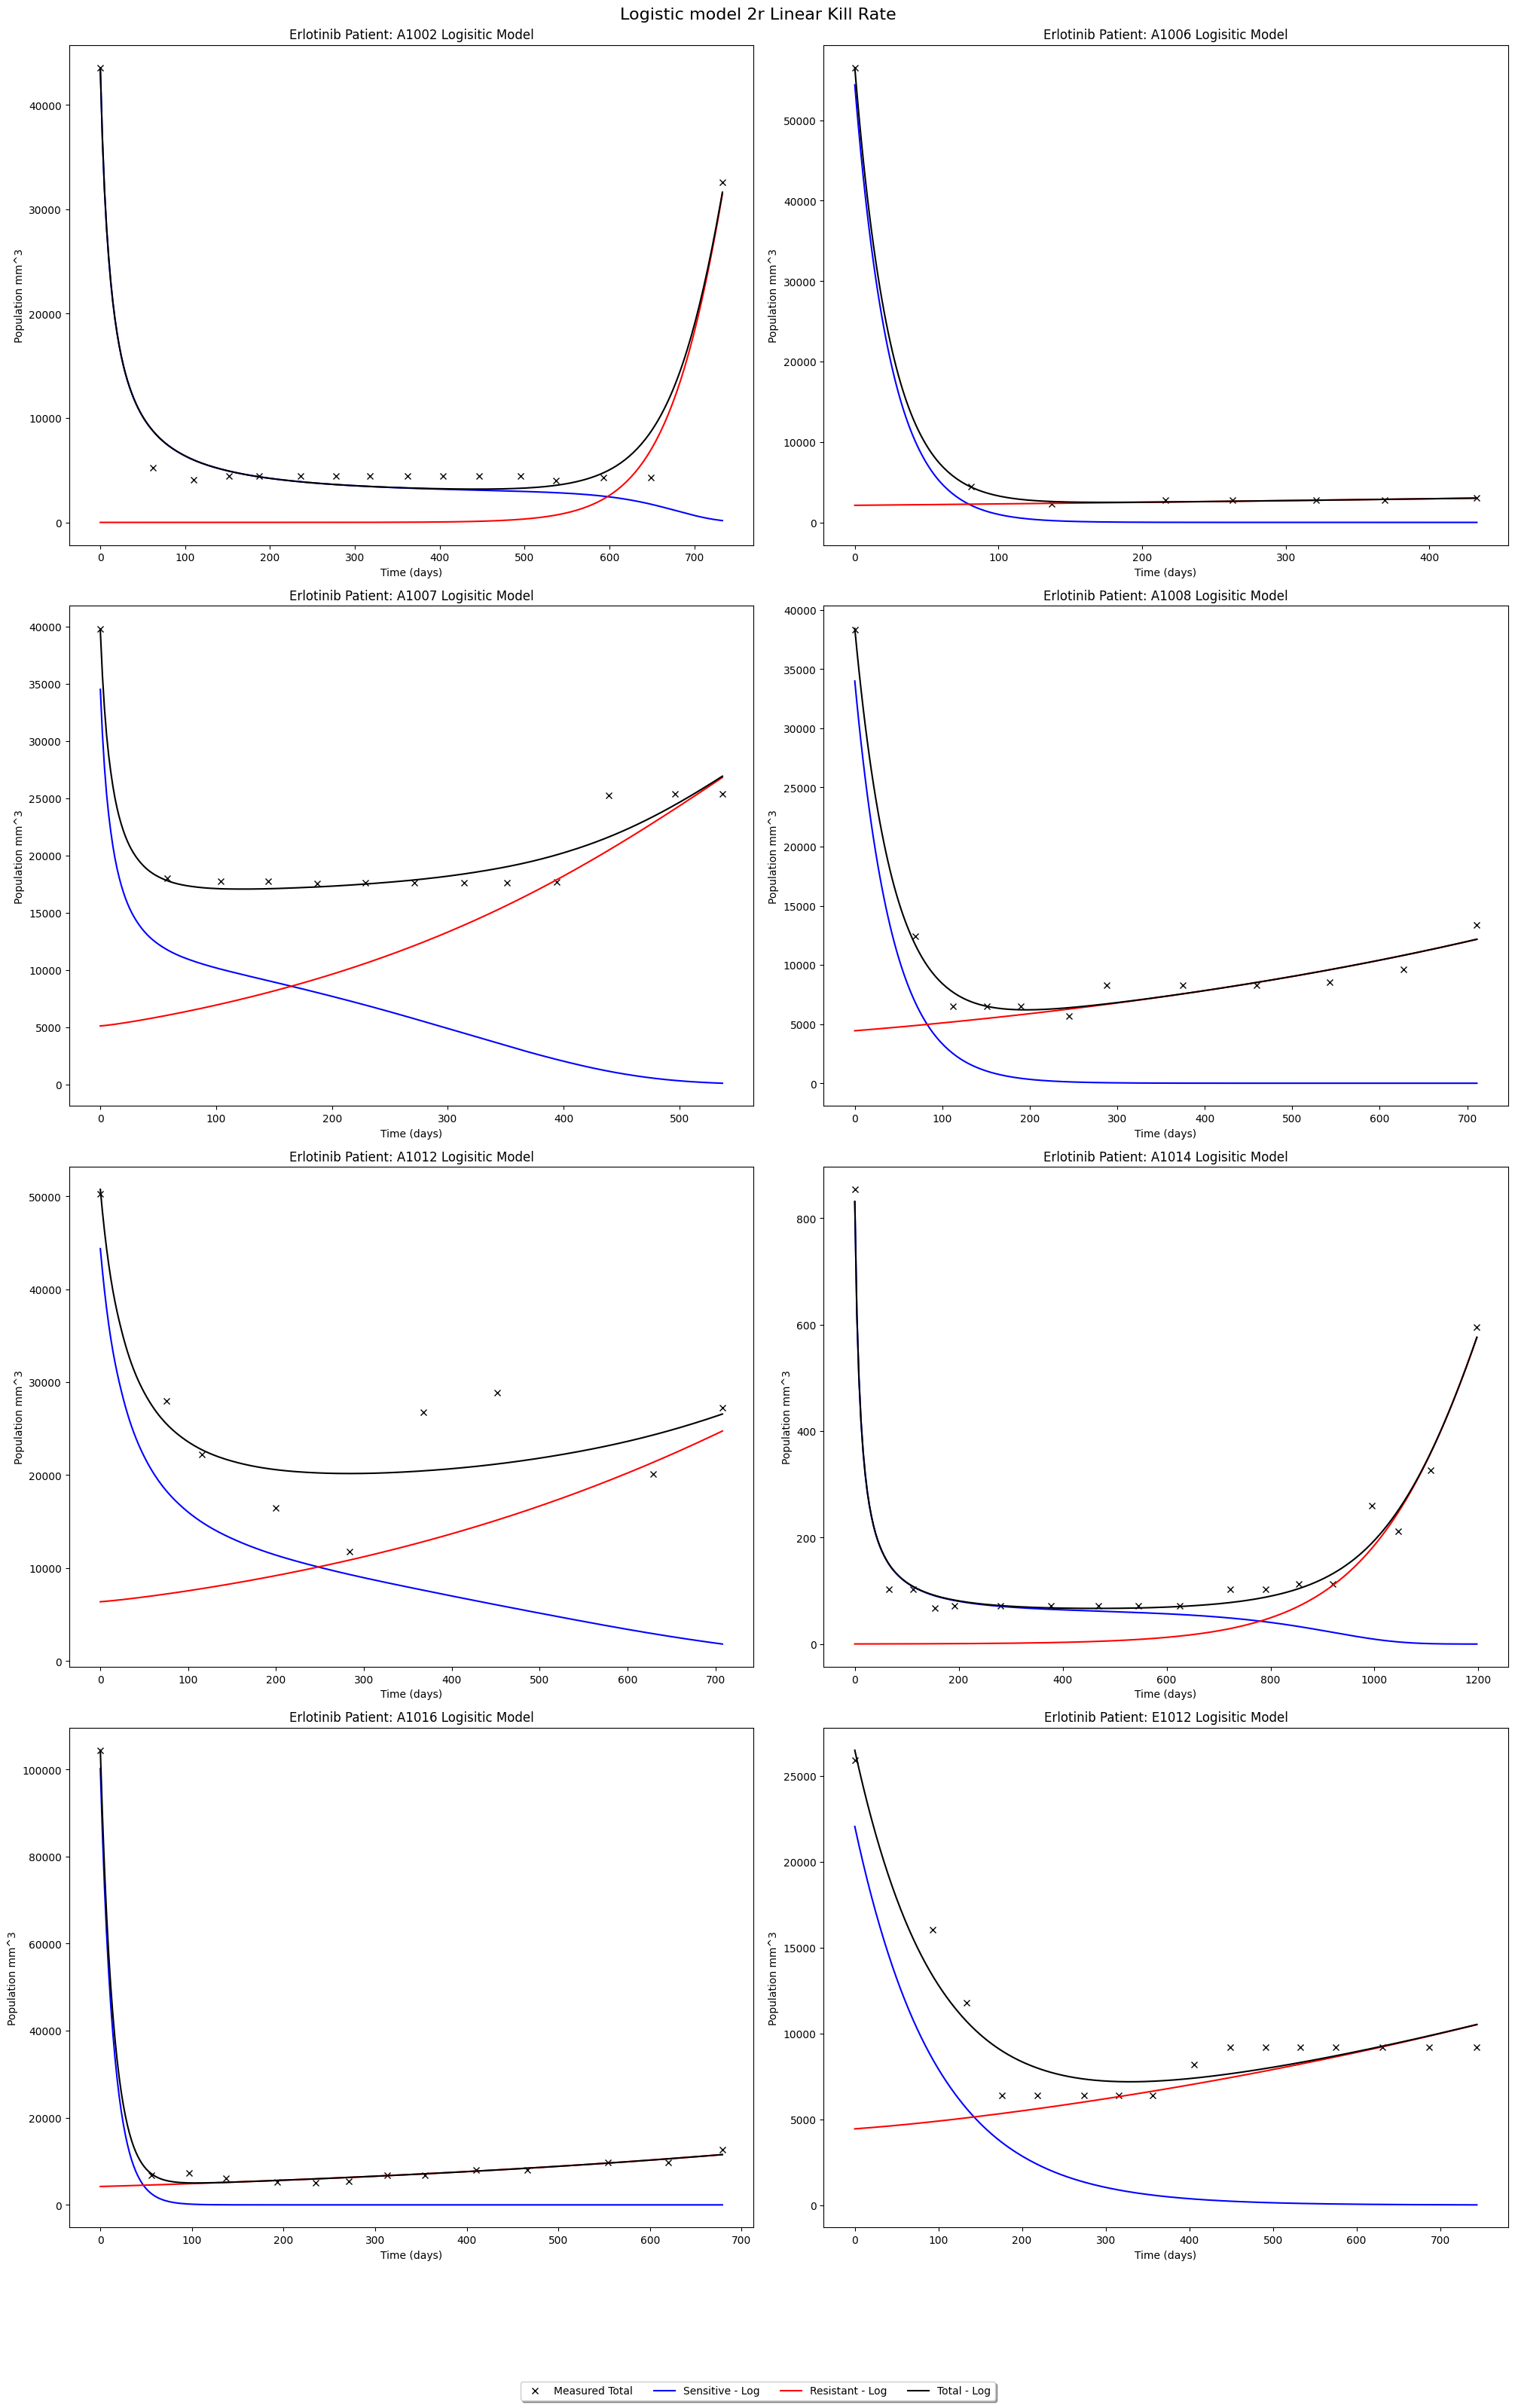

In [34]:
# setting up subplots
df = eight_plus_df
unique_IDs = df.ID.unique()   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = md_constant_log_linear_2r[id]
    init_populations_log = optimal_params_log[4:6]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:4]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {id} Logisitic Model') 
    formatter = ticker.FuncFormatter(lambda x, pos: '%d' % (x * 1e3))
    ax.yaxis.set_major_formatter(formatter)

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model 2r Linear Kill Rate', fontsize=16)  
plt.show()

##### extending time

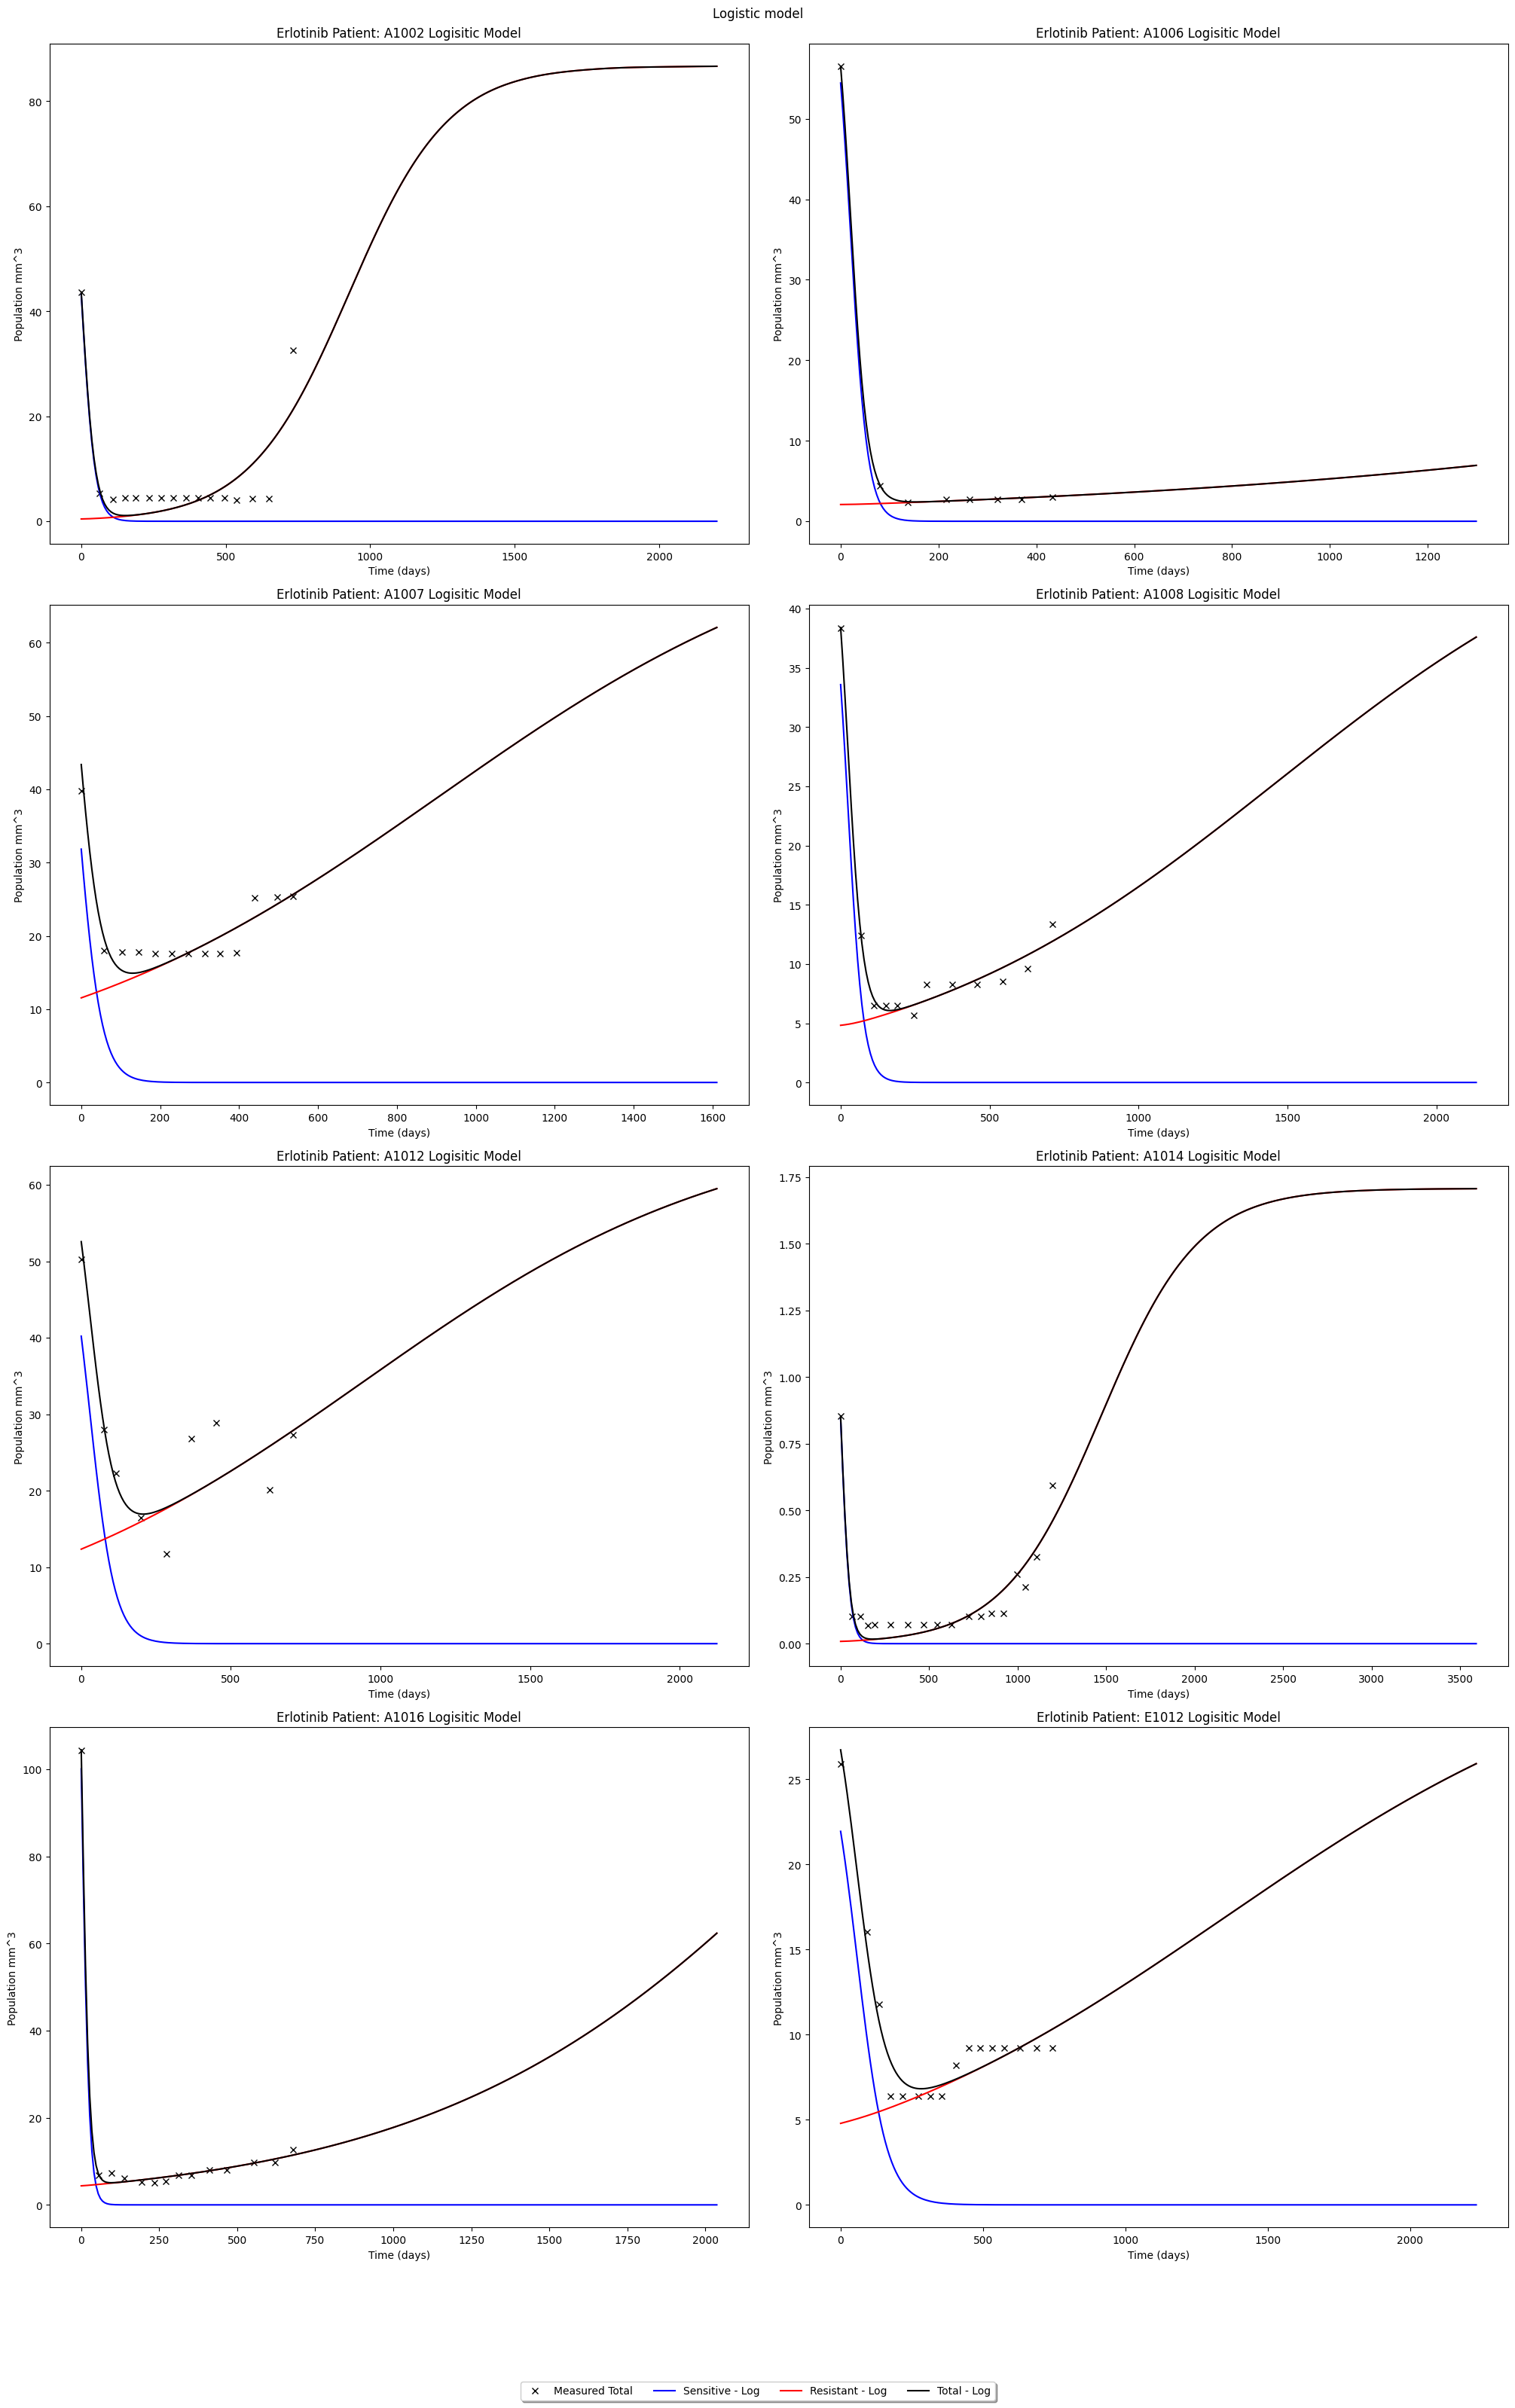

In [11]:
sim_time_factor = 3
df = eight_plus_df
unique_IDs = df.ID.unique()  
# setting up subplots
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 300)

    optimal_params_log = master_dictionary1[id]
    init_populations_log = optimal_params_log[6:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:6]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {id} Logisitic Model') 
    # formatter = ticker.FuncFormatter(lambda x, pos: '%d' % (x * 1e3))
    # ax.yaxis.set_major_formatter(formatter)

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### zhang

Switch points for patient 1: [(0.0, 26.885628542847613), (928.7762587529176, 7330.0)]
Switch points for patient 2: [(0.0, 30.320106702234078)]
Switch points for patient 3: [(0.0, 57.29909969989997), (927.5291763921307, 5370.0)]
Switch points for patient 4: [(0.0, 47.41580526842281), (2183.4978326108703, 7110.0)]
Switch points for patient 5: [(0.0, 92.07069023007668), (1577.0056685561854, 7080.0)]
Switch points for patient 6: [(0.0, 31.930643547849282), (1472.8009336445482, 11970.0)]
Switch points for patient 7: [(0.0, 15.8486162054018), (2630.8702900966987, 6790.0)]
Switch points for patient 8: [(0.0, 111.6372124041347), (2232.744248082694, 7440.0)]


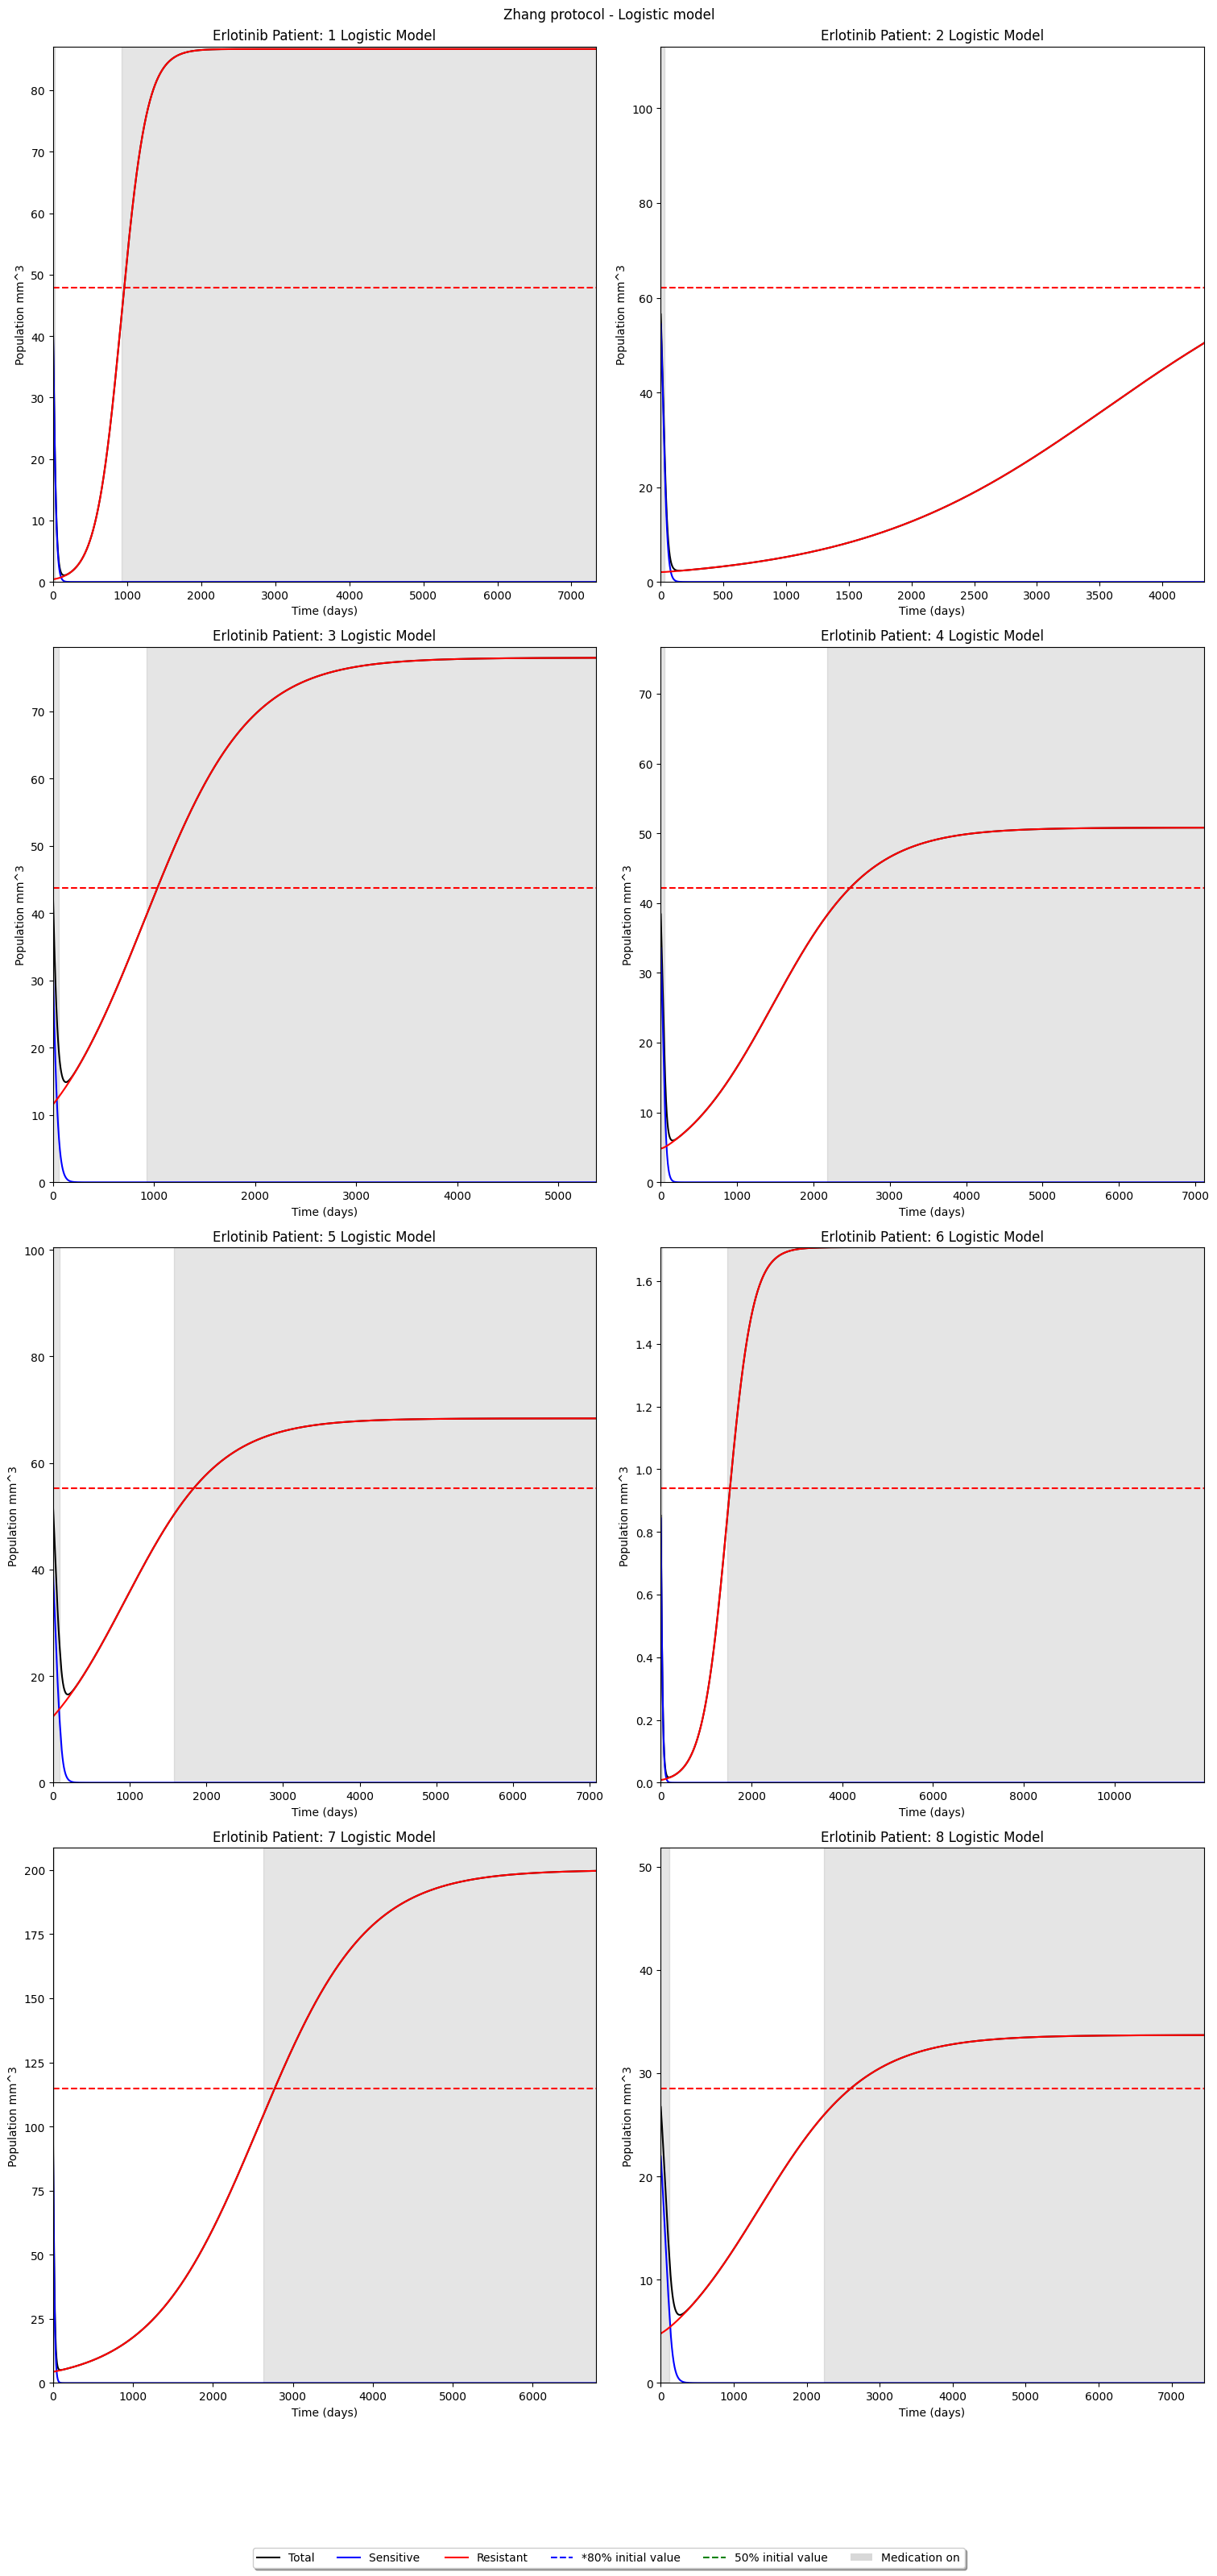

In [12]:
#### colour bars
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15,30), constrained_layout=True)
sim_time_factor = 10 ### how much to extend the time

master_dictionary_copy0 = copy.deepcopy(master_dictionary1) # parameters for medication off
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

Med_on = master_dictionary1
Med_off = master_dictionary_copy0

# fitting data, switching medication off and on
for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    switch_off = 0.5*data[0] # switch off medication when tumor volume is half of initial volume
    switch_on = data[0] # switch on medication when tumor volume is = initial volume
    tspan = np.linspace(0, sim_time_factor*days[-1], 3000)

    # Initialize with medication on
    optimal_params = Med_on[id]
    #init_populations = [optimal_params[3],data[0]-optimal_params[3]]
    init_populations = optimal_params[6:-1]

    # Initialize sum_pops_log
    sum_pops = np.zeros_like(tspan)
    sensitive_values = []
    resistant_values = []
    switch_points = [] # list of switches for plotting
    med_on = True
    switch_point = tspan[0]

    # Simulate with medication switching
    for i, t in enumerate(tspan[:-1]):
        # Solve for the next time step
        pred_data = solve_ivp(system_ode_logistic, [t, tspan[i+1]],
                                init_populations, dense_output=True,
                                args = tuple([optimal_params[:6]]))
        sum_pops[i] = np.sum(pred_data.sol(tspan[i]), axis=0)
        sensitive_values.append(pred_data.sol(tspan[i])[0])
        resistant_values.append(pred_data.sol(tspan[i])[1])

        # Calculate the slope
        if i > 0:
            slope = sum_pops[i] - sum_pops[i-1]

            # Switch medication off if conditions are met
            if sum_pops[i] <= switch_off and slope < 0:
                optimal_params = Med_off[id] 
                # If med_on was active, shade the region where it was on
                if med_on:
                    switch_points.append((switch_point, t))
                    med_on = False
                    switch_point = t       

            # Switch medication on if conditions are met
            elif sum_pops[i] >= switch_on and slope > 0:
                optimal_params = Med_on[id]
                if not med_on:
                    switch_point = t
                    med_on = True   

        # Update initial populations for the next time step
        init_populations = pred_data.sol(tspan[i+1])

    # Solve for the last time step
    pred_data = solve_ivp(system_ode_logistic, [tspan[-2], tspan[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:6]]))
    sum_pops[-1] = np.sum(pred_data.sol(tspan[-1]), axis=0)
    if med_on:
        switch_points.append((switch_point, tspan[-1]))  

        # Print switch points for the current ID
    print(f'Switch points for patient {index +1}: {switch_points}')

    
    # Store sensitive and resistant values
    sensitive_values.append(pred_data.sol(tspan[-1])[0])
    resistant_values.append(pred_data.sol(tspan[-1])[1])

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    #ax.plot(days, data, 'kx', label='Measured Total') 
    #ax.axhline(y=0.5*data[0], color='g', linestyle='--') ### 50% line, switch off
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') 
    ax.plot(tspan, sum_pops, 'k-', label='Total') # plot logistic model
    ax.plot(tspan, sensitive_values, 'b-', label='Sensitive') # plot logistic model
    ax.plot(tspan, resistant_values, 'r-', label='Resistant') 

   # Shade regions for all switch points
    for sp in switch_points:
        ax.axvspan(sp[0], sp[1], color='grey', alpha=0.2)

    #set axis labels
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {index +1} Logistic Model') 
    ax.set_ylim(0, 2*data[0])
    ax.set_xlim(0, tspan[-1])
  
for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [
    #Line2D([0], [0], marker='x', color='k', label='Measurement', linestyle='None'),
    Line2D([0], [0], color='k', label='Total'),
    Line2D([0], [0], color='b', label='Sensitive '),
    Line2D([0], [0], color='r', label='Resistant'),
    Line2D([0], [0], color='b', linestyle='--', label='*80% initial value'),
    Line2D([0], [0], color='g', linestyle='--', label='50% initial value'),
    Patch(facecolor='grey', alpha=0.3, label='Medication on')  
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Zhang protocol - Logistic model')  
plt.show()


##### with first data point removed

In [13]:
#### use ten plus tumors df
df = eight_plus_df.groupby('ID').filter(lambda x: x['days'].nunique() >= 8) # select patients with at least 8 data points since there are 7 parameters now

unique_IDs = df.ID.unique()
master_dictionary = {} # store optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    max_value = max(data[0], data[-1])
    print("Working on patient:", id, " Number of data points:", len(days))
    bounds =   [(1e-3, 1e-1),#rs
                (1e-3, 1e-1),#rr
                (1, 10),#alpha_SR
                (1, 10),#alpha_RS
                (1.5*max_value, 20*max_value),#K
                (1, 50),#lambda_S
                (0.8*data[0], 1.1*data[0]),# S_0
                (0.01*data[0],0.3*data[0])] # R_0

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data,'rmse'),disp=True)
  
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
differential_evolution step 1: f(x)= 13.6016
differential_evolution step 2: f(x)= 5.28425
differential_evolution step 3: f(x)= 5.28425
differential_evolution step 4: f(x)= 5.28425
differential_evolution step 5: f(x)= 5.11758
differential_evolution step 6: f(x)= 5.11758
differential_evolution step 7: f(x)= 5.11758
differential_evolution step 8: f(x)= 5.09473
differential_evolution step 9: f(x)= 4.87295
differential_evolution step 10: f(x)= 4.87295
differential_evolution step 11: f(x)= 4.87295
differential_evolution step 12: f(x)= 4.77959
differential_evolution step 13: f(x)= 4.77833
differential_evolution step 14: f(x)= 4.77833
differential_evolution step 15: f(x)= 4.77833
differential_evolution step 16: f(x)= 4.64412
differential_evolution step 17: f(x)= 4.64412
differential_evolution step 18: f(x)= 4.64232
differential_evolution step 19: f(x)= 4.64232
differential_evolution step 20: f(x)= 4.64232
differential_evolution step 21: f(x)

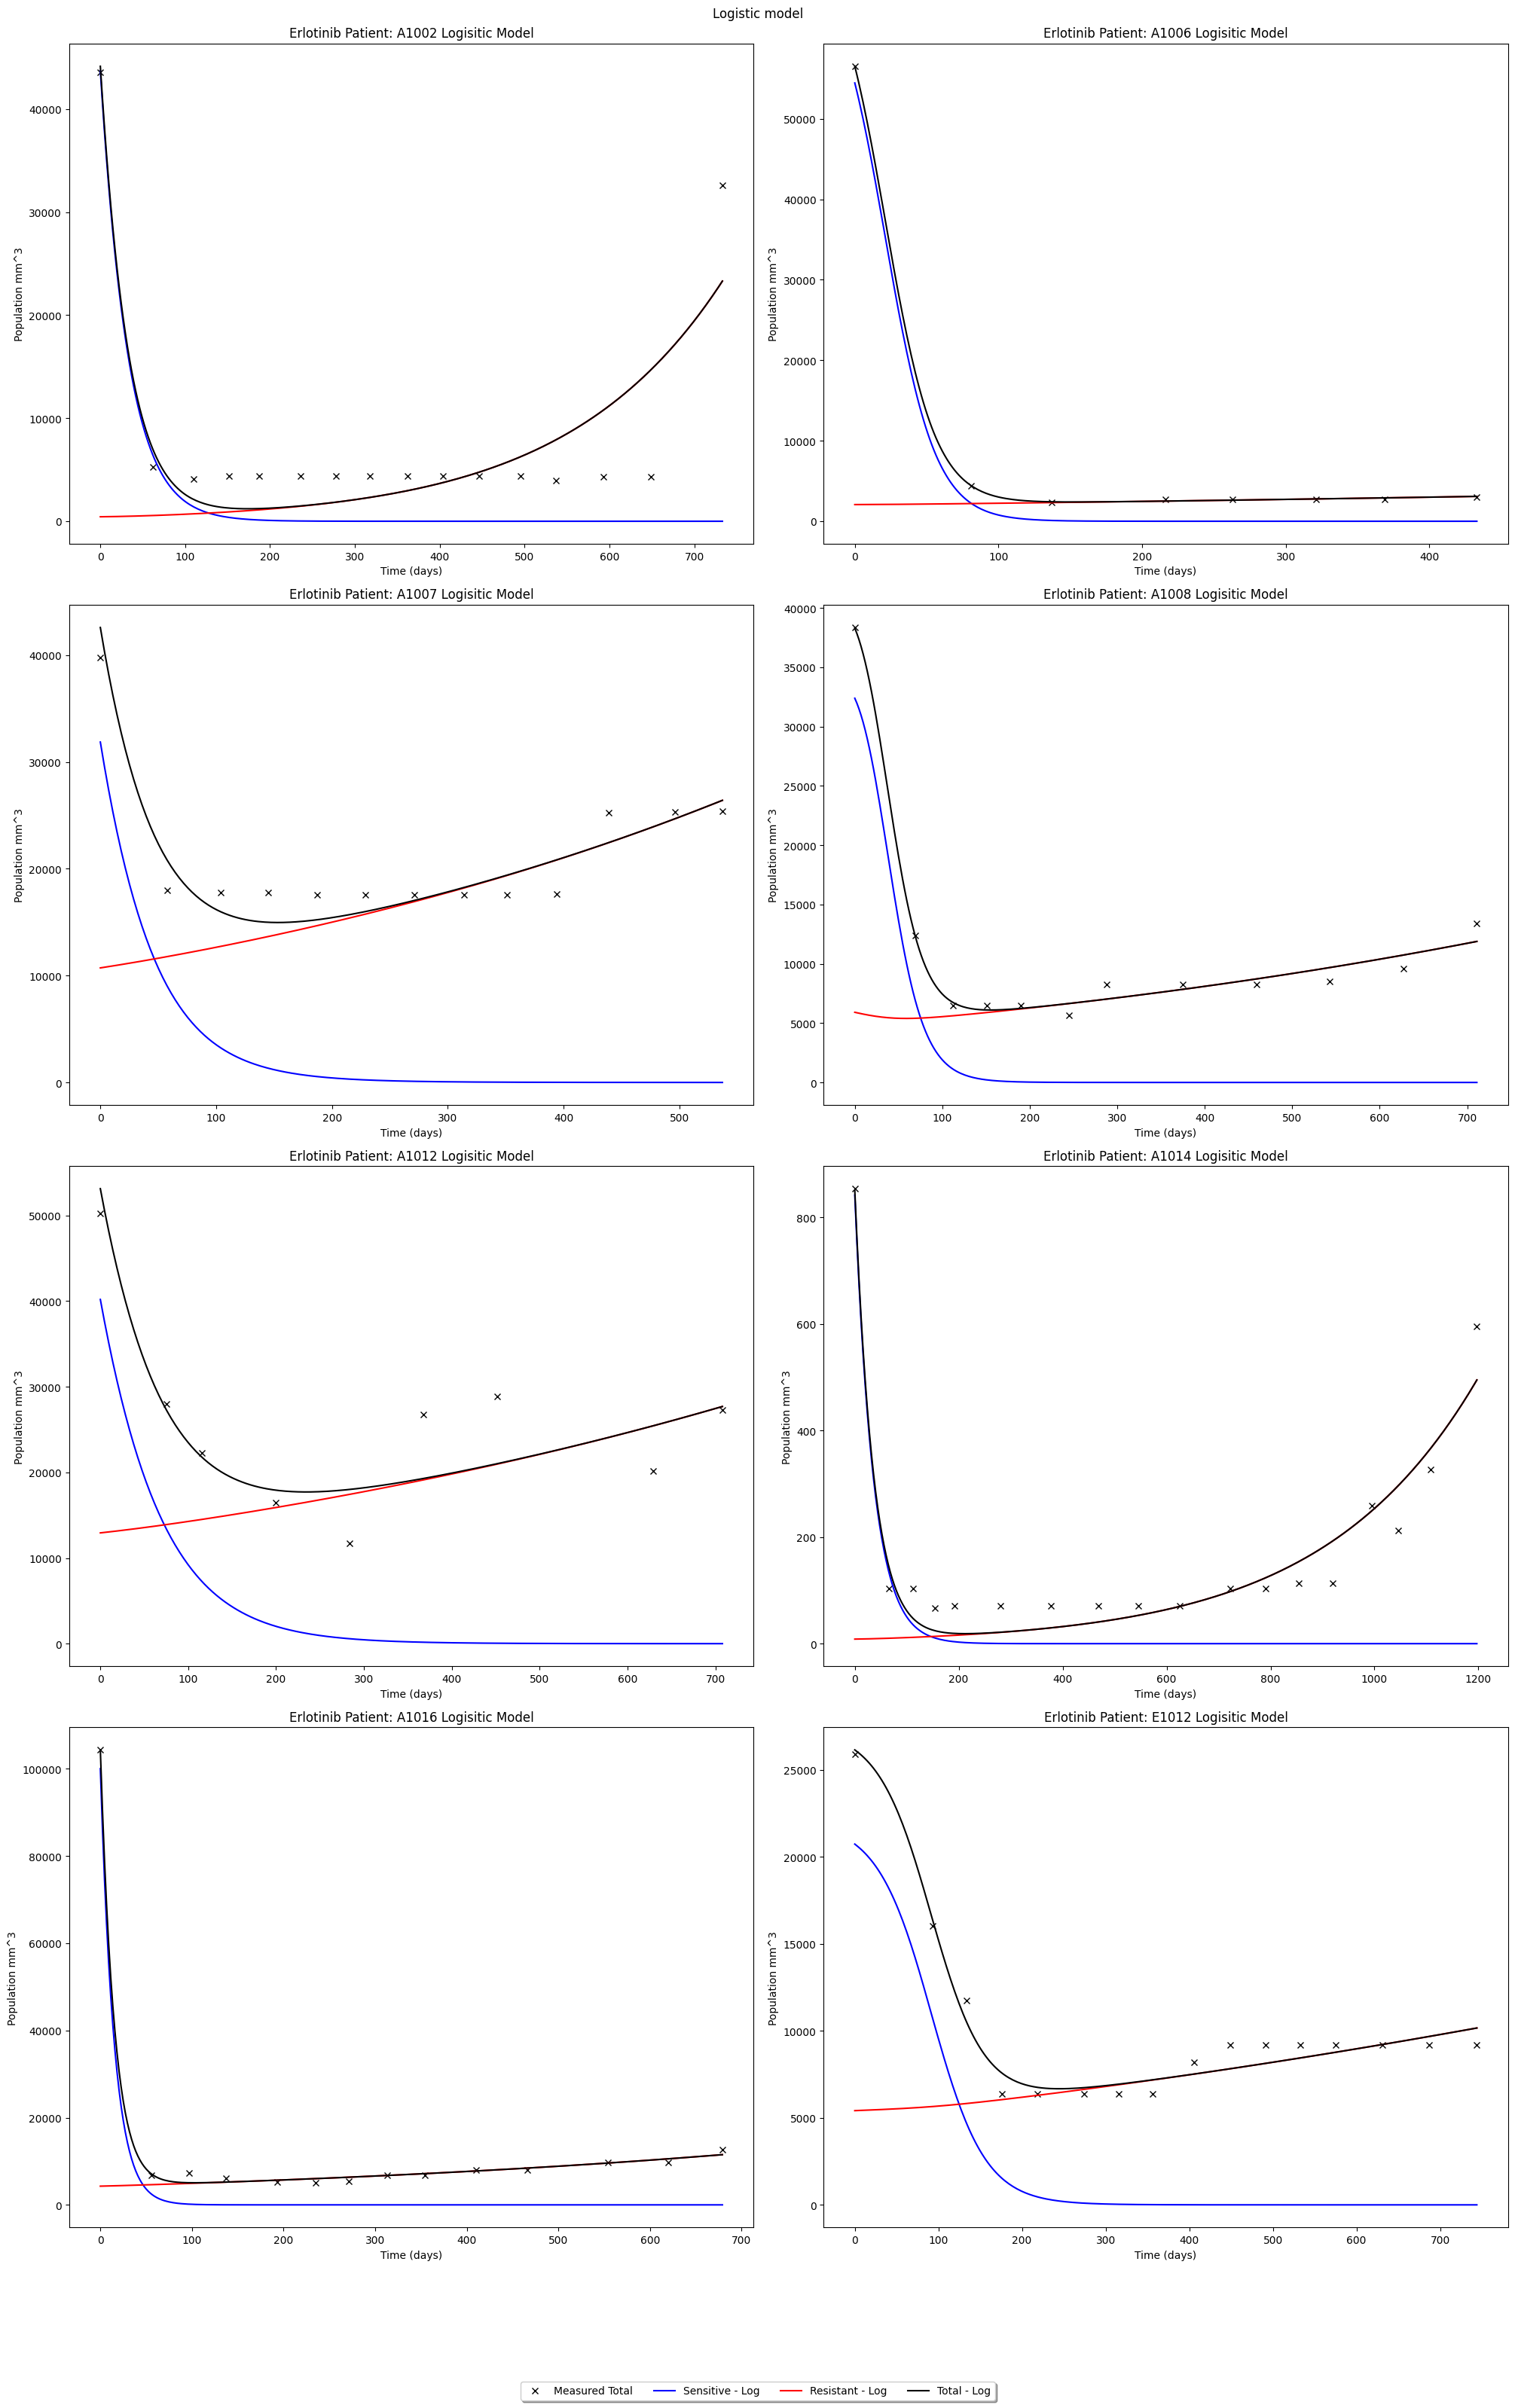

In [14]:
# setting up subplots
df = eight_plus_df
unique_IDs = df.ID.unique()   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_vol_cm[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[6:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:6]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population mm^3')
    ax.set_title(f'Erlotinib Patient: {id} Logisitic Model') 
    formatter = ticker.FuncFormatter(lambda x, pos: '%d' % (x * 1e3))
    ax.yaxis.set_major_formatter(formatter)

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()